<img src="BINGO_AVATAR.png" alt="Logo" class="center" width=20%>

# Primeiro Notebook  com Instruções para o Mestrado

1. Habilite o **subssistema do windows para o Linux** conforme as instruções em [aqui](https://www.techtudo.com.br/noticias/2016/04/como-instalar-e-usar-o-shell-bash-do-linux-no-windows-10.ghtml)
    - Clique em **INICIAR** e acesse **Configurações**, selecione **Atualizações e Segurança** e clique em **Modo de Desenvolvedor**.
    - Clique na barra de busca e digite: **Ativar e Desativar Recursos do Windows** e marque a opção **Windows Subsystem for Linux**, clique **OK**. Reinicie.
2. Instalando o Miniforge:
    - Siga os comandos abaixo, um de cada vez e leia atentamente as saídas.
    ```bash 
    apt-get update
    apt-get install nano git wget build-essential 
    wget https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh
    chmod u+x Miniforge3-Linux-x86_64.sh
    ./Miniforge3-Linux-x86_64.sh
    ```
3. Crie um ambiente conda de trabalho com o Python, para encapsular as suas necessidades de bibliotecas.
    - No **bash shell* do windows:
    ```
    conda create --name mestrado 
    conda activate mestrado
    conda install astropy numpy scipy matplotlib pandas jupyter ipykernel jupyter_contrib_nbextensions
    python -m ipykernel install --user --name=mestrado
    ```
    
    Agora edite o arquivo `~/.bashrc` com o comando `nano ~/.bashrc` e coloque na última linha o conteúdo abaixo:
    ```
    alias jupyter-notebook="~/.local/bin/jupyter-notebook --no-browser"
    ```
    Para sair e salvar suas alterações digite `CTRL+X` e depois `Y`+ `ENTER`.
    
    Feche e abra o seu terminal novamente. Agora você pode abrir o `jupyter` com o comando `jupyter-notebook`. Observe que um token aparece na tela. Copie este token com o mouse, abra um navegador, aponte seu navegador para `localhjost:8888` e cole o token quando solicitado.
    
    
1. Para instalar o `miniforge` diretamente pelo windows siga as instruções em https://github.com/conda-forge/miniforge
    - Fazer o [download](https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Windows-x86_64.exe)
    - Clique duas vezes e realize a instalação. Alternativamente, rode:
    ```
    start /wait "" build/Miniforge3-Windows-x86_64.exe /InstallationType=JustMe /RegisterPython=0 /S /D=%UserProfile%\Miniforge3
    ```
    
**IMPORTANTE**: O que você precisa é ter um ambiente python funcionando e capaz de encapsular as suas diferentes necessidades de bibliotecas. Acredite, você vai precisar de mais do que um ambiente e você irá se deparar com o problema de ter versões incompatíveis de bibliotecas mais cedo do que tarde.

Se vopcê usar o método que se parece com o Linux, você sempre vai poder ter suporte do professor, que não tem nenhuma máquina windows para testar. As receitas publicadas seempore serão para Linux. Se você quiser manter tudo no mundo windows, tudo bem, mas não pode contar com ajuda.

## Alunos
### Alane
Vai usar mais o Mathematica do que o Jupyter, se quiser, pule estas etapas.

### George, Everton
Precisam incluir alguns pacotes adicionais. Alguns não são necessários para um mas são para outro ou vice-versa, enquanto for possível, vamos manter o mesmo ambiente base de desenvolvimento.

```bash
conda create --name jose 
conda activate jose
conda install -c bccp nbodykit
conda install -c conda-forge  ipykernel astropy astroquery pandas numpy matplotlib scipy healpy pysm3 lmfit namaster mpi4py statsmodels
python -m pip install multiprocess gpy scikit-learn pyccl camb cobaya skyfield
cobaya-install cosmo -p ./
python -m ipykernel install --name jose --user
cd Clones/
git clone https://github.com/philbull/FastBox.git
cd FastBox
python setup.py install --user
```


## Passos Básicos

In [1]:
# Mostra todos os resultados da célula, não apenas o último
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"

In [25]:
from io import StringIO
import re
import requests
from astropy import units as u
import astropy.coordinates as coord
from astropy.cosmology import LambdaCDM
from astropy.cosmology import Planck18
from astroquery.simbad import Simbad
from lmfit import Model
import matplotlib.cm as cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

## Diagrama de Hubble Original

In [3]:
# Conexão a internet para obter as informações de Simbad.
hubble_data = pd.read_csv('../data/external/hubble_historical_data.csv', delimiter=";", decimal=",")
s = Simbad()
s.add_votable_fields('ra(d)', 'dec(d)')
s.remove_votable_fields('coordinates')
hubble_data['alpha'] = hubble_data['OBJECT'].apply(lambda row: s.query_object(row)['RA_d'][0])
hubble_data['delta'] = hubble_data['OBJECT'].apply(lambda row: s.query_object(row)['DEC_d'][0])

In [6]:
# Manipulando as tabelas Astropy para um array numpy.
RA = coord.Angle(hubble_data['alpha'].to_numpy()*u.deg).wrap_at(180*u.deg)
DEC = coord.Angle(hubble_data['delta'].to_numpy()*u.deg)
OBJECTS = hubble_data['OBJECT'].to_numpy()

In [7]:
# O movimento dos objetos tem que ser corrigido pelo movimento solar. 
# No artigo tem uma proposta de procedimento para ser realizado.
df = pd.DataFrame(columns=['v','K','X','Y','Z'])
df['v'] = hubble_data['v']
df['K'] = hubble_data['r']
df['X'] = np.cos(np.radians(hubble_data['alpha']))*np.cos(np.radians(hubble_data['delta']))
df['Y'] = np.sin(np.radians(hubble_data['alpha']))*np.cos(np.radians(hubble_data['delta']))
df['Z'] = np.sin(np.radians(hubble_data['delta']))
# Jeito intuitivo de definir dependência linear múltipla, utilizando o pacote statsmodel.
lm = smf.ols(formula='v ~ K + X + Y + Z', data=df).fit()
# print a summary of the fitted model
df['v_fit']=lm.fittedvalues
dis_corrected = df['K'].to_numpy().reshape((-1, 1))
vel_corrected = df['v_fit'].to_numpy()
# Realiza ajuste linear entre a velocidade e a distância, o coeficiente aqui é a constante de Hubble
model_corrected = LinearRegression().fit(dis_corrected,vel_corrected)

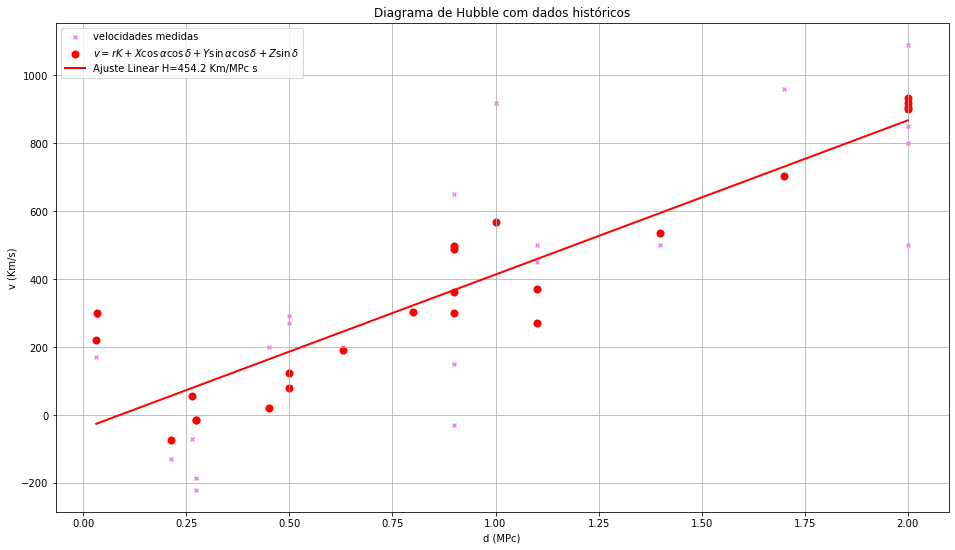

In [8]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('Diagrama de Hubble com dados históricos')
ax.scatter(hubble_data['r'], hubble_data['v'], marker = 'x', s=15, color='violet', label="velocidades medidas")
#ax.plot(dis,model.predict(dis), label=r'Ajuste Linear H={:.1f} Km/MPc s'.format(model.coef_[0]),
#       linewidth=2, color='blue')
ax.scatter(hubble_data['r'], lm.fittedvalues, 
           linewidth=2, color='red', label=r'$v = r K + X \cos \alpha \cos \delta + Y \sin \alpha \cos \delta + Z \sin \delta$')
ax.plot(dis_corrected, model_corrected.predict(dis_corrected), 
        label=r'Ajuste Linear H={:.1f} Km/MPc s'.format(model_corrected.coef_[0]),
        linewidth=2, color='red')
ax.set_xlabel('d (MPc)')
ax.set_ylabel('v (Km/s)')
plt.legend()
plt.grid()
plt.show();
#fig.savefig('./images/original_hubble.png', dpi = 600);

## Supernovas

In [26]:
URL_PANTHEON = "https://raw.githubusercontent.com/dscolnic/Pantheon/master/data_fitres/Ancillary_G10.FITRES"
response = requests.get(URL_PANTHEON) 
text = StringIO(response.content.decode("utf-8"))

In [27]:
WHITESPACE = '\s+'
dados = pd.read_table(text, header=None, comment="#", sep=":")
# Variáveis utilizadas no conjunto de dados
headers = dados[dados[0] == 'VARNAMES'][1].values[0]
headers = [item.strip() for item in re.split(WHITESPACE, headers) if item]
num_colunas = len(headers)
# Tipos de variáveis. Não é estritamenter correto, mas atende bem os propósitos. 
# Alguns inteiros foram mapeados para valores string categoricos ou para float. 
#Sem prejuízo para a análise.
values = ['string', 'float']
DTYPE_DICT = {key: values[0] if (headers.index(
    key) < 5) else (values[1]) for key in headers}
# Dados de supernovas estão em dicionário. Cada chave corresponde a um registro 
# com todas as variáveis definidas para o header. 
# Basta fatiar o conjunto, eliminar espaços espúrios com trim e separar 
# em campos delimitados por espaço com uma expressão regular.
dadosSN = dados[dados[0] == 'SN'][1].str.strip().tolist()
SNDATA_table = [re.split(WHITESPACE, row) for row in dadosSN]
# DataFrame final com dados e cabeçalho.
SNDATA_df = pd.DataFrame(SNDATA_table, columns=headers)
SNDATA_df = SNDATA_df.astype(dtype=DTYPE_DICT)

In [28]:
# Incluindo informação de nomes de catálogos de acordo com a chave provida.
# Simplificando o nome dos catálogos um pouco.
SURVEYS = ['CFA', 'CSP', 'SDSS', 'SNLS', 'SCP', 'CANDELS', 'GOODS', 'Pan-STARRS1']
SURVEY_NAMES = {61: 'CFA', 62: 'CFA', 63: 'CFA', 64: 'CFA', 65: 'CFA', 66: 'CFA',
                5: 'CSP', 1: 'SDSS', 4: 'SNLS', 101: 'SCP', 106: 'CANDELS', 100: 'GOODS', 15: 'PS1'}
SURVEY_DF = pd.DataFrame([SURVEY_NAMES]).T.reset_index().rename(
    columns={'index': 'IDSURVEY', 0: 'SURVEY_NAME'})
SURVEY_DF = SURVEY_DF.astype({'IDSURVEY': 'string', 'SURVEY_NAME': 'string'})
SNDATA_df = SNDATA_df.merge(SURVEY_DF, on='IDSURVEY', how='left')

In [29]:
def distanceModulus(dL):
    mu=5.0*(np.log10(dL))+25.0
    return mu

In [30]:
H0 = Planck18.H0.value
deSitter = LambdaCDM(H0=H0, Om0=0, Ode0=1)
empty = LambdaCDM(H0=H0, Om0=0, Ode0=0)

In [47]:
# Cosmologias para painel superior
cosmologias = ['Planck2018', 'deSiter', 'Vazio']
zlin = np.linspace(0.01,2.5,100)
dL_cosmo = [Planck18.luminosity_distance(zlin).value, 
            deSitter.luminosity_distance(zlin).value,
            empty.luminosity_distance(zlin).value]
dL_todiff = Planck18.luminosity_distance(SNDATA_df['zCMB'].values).value
mu_cosmo = [distanceModulus(dl) for dl in dL_cosmo]
# Pontos Painel inferior
mu_diff = np.asarray(100*(SNDATA_df['MU']-distanceModulus(dL_todiff))/distanceModulus(dL_todiff))
mu_diff_err = np.asarray(100*np.abs(mu_diff/distanceModulus(dL_todiff)))
zcmb = np.asarray(SNDATA_df['zCMB'])

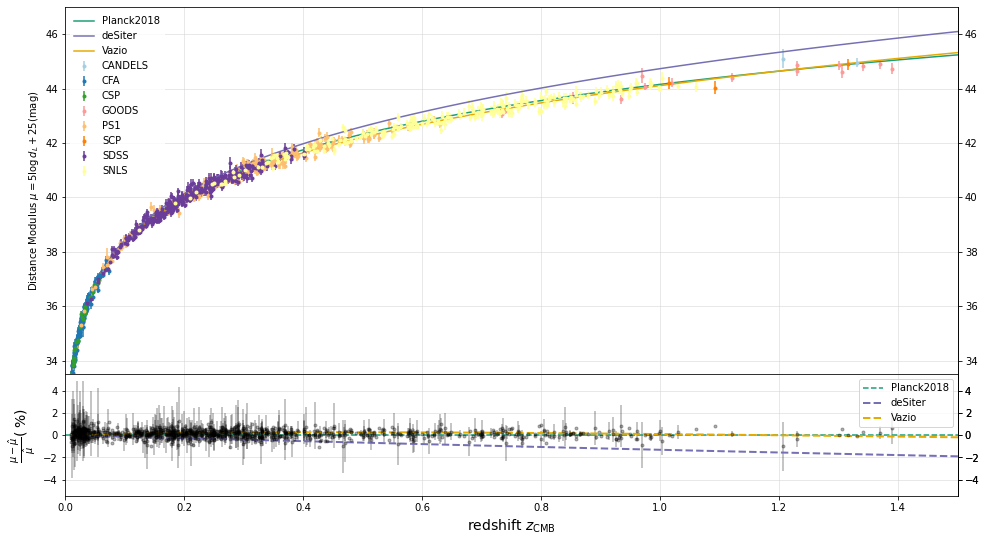

In [48]:
cores = cm.Paired

fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(4, 1, hspace=0)
# Painel Superior
ax1 = fig.add_subplot(gs[:3, 0])
# Cores por grupo
grouped = SNDATA_df.groupby('SURVEY_NAME')
surveys = list(grouped.groups.keys())
norm = colors.Normalize(vmin=0, vmax=len(surveys))
for key, group in grouped:
    cor_index = cores(norm(surveys.index(key)))
    plt.errorbar(x='zCMB', y='MU', yerr='MUERR', label=key,
                 color=cor_index, fmt='.', data=group)
# Curvas modelos cosmológicos
cores = cm.Dark2
norm = colors.Normalize(vmin=0, vmax=len(cosmologias))
for ii, cosmo in enumerate(cosmologias):
    cor_index = cores(norm(ii))
    plt.plot(zlin, mu_cosmo[ii], color=cor_index, label=cosmo)
# Formato
ax1.label_outer()
ax1.set_ylabel(r"Distance Modulus $\mu = 5 \log d_L +25$(mag)")
ax1.secondary_yaxis("right")
ax1.set_ylim([33.5,47])
ax1.grid(which='major', color='lightgray', linewidth=.5)
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor("white")
leg.get_frame().set_alpha(.8)
# Painel Inferior
ax2 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax2.errorbar(x=zcmb, y=-mu_diff, yerr=mu_diff_err,
             fmt='k.', errorevery=2, alpha=0.3)
ax2.axhline(0, label=cosmologias[0], linestyle='dashed', color=cores(norm(0)))
ax2.plot(zlin, -100*(mu_cosmo[1]-mu_cosmo[0])/mu_cosmo[0],
         label=cosmologias[1], linestyle='dashed', linewidth=2, color=cores(norm(1)))
ax2.plot(zlin, -100*(mu_cosmo[2]-mu_cosmo[0])/mu_cosmo[0],
         label=cosmologias[2], linestyle='dashed', linewidth=2, color=cores(norm(2)))
# Formato
ax2.set_ylim([-5.5, 5.5])
ax2.set_xlim([0, 1.5])
ax2.secondary_yaxis("right")

ax2.set_xlabel(r"redshift $z_{\mathrm{CMB}}$", fontsize=14)
ax2.set_ylabel(r"$\frac{\mu-\hat\mu}{\hat \mu} (\;\%)$", fontsize=14)
ax2.secondary_yaxis("right")
plt.legend()
ax2.grid(which='major', color='lightgray', linewidth=.5)
plt.show();